In [111]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [112]:
!pip install jovian --upgrade --quiet

In [113]:
project_name='my-project-Leagure-of-Legends'

# League of Legends (first 10 minutes) dataset analysis

This dataset contains the first 10 minutes' stats of approximately 10k ranked games (SOLO QUEUE) from a high ELO rating (DIAMOND I to MASTER). 
Thus, players have roughly the same experience level.

Each game is unique. As such the `gameId` is unique as well.

There are 19 features per team (38 in total) collected after 10min in-game. This includes kills, deaths, gold, experience, level etc. It may be necessary to do some feature engineering to get more insights into the data.

The column `blueWins` is the target value (the value we are trying to predict). A value of `1` means the blue team has won and  `0` means red wins (blue thus lost).

## Analysing the data

Before any models are trained with the data, we must first determine if the data needs some conditioning. 
Are there any boolean values which needs to be changed, are there any missing data and can some of the data be removed.

### Import data

In [114]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        FILE_PATH = filename
        print(f"Full path to data: {os.path.join(dirname, filename)}")

Full path to data: /kaggle/input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv


In [115]:
FILE_PATH = '../input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv'

In [116]:
dataframe = pd.read_csv(FILE_PATH)
print(dataframe.shape)
dataframe.head()

(9879, 40)


,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


### View data

We can now start visually checking the data to see if there are any errors or irregularities which can influence the model later on. The data consist of 9879 matches with 39 input columns and 1 output column (`blueWins`).
Next, we can visually check to see if there are any missing data.

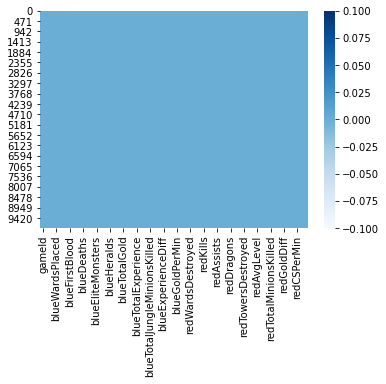

In [117]:
sns.heatmap(dataframe.isnull(),cmap='Blues')

The graph shows that there are no missing values which is great! The next thing to do is to check to see if there are any categorical inputs which need to be changed to numerical inputs.

In [118]:
categorical_cols = dataframe.select_dtypes(exclude=[np.number]).keys()
categorical_cols

Index([], dtype='object')

There are no categorical inputs in the data with the inputs either being of the type `int64` or `float64`. 
As mentioned before, we can remove the `gameID` column as it is unique for each game and will not add any value when training the model.

In [119]:
dataframe.drop(['gameId'],inplace=True,axis=1)
dataframe.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,0,15,0,0,7,11,4,1,1,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,0,43,1,0,4,5,5,1,0,1,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,0,75,4,0,6,6,6,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


The Red team's stats and the Blue team's stats can be seperated for some additional analysis.

In [120]:
blue_features=[]
red_features=[]
for col in list(dataframe):
    if(col[0]=='r'):
        red_features.append(col)
    if(col[0]=='b'):
        blue_features.append(col)

In [121]:
blue = dataframe[blue_features]
blue.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0
1,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2
2,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3
3,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7
4,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0


In [122]:
red_features.append("blueWins")
red = dataframe[red_features]
red.head()

,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7,0
1,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0,0
2,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5,0
3,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8,0
4,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4,0


It is also a good idea to see if there data is evenly distributed between wins for the Blue team and wins for the Red team.

In [123]:
Red_win=len(dataframe['blueWins']==0)
Blue_win=len(dataframe['blueWins']==1)
print(f"Blue team wins {Blue_win} times")
print(f"Red team wins {Red_win} times")

Blue team wins 9879 times
Red team wins 9879 times


Both teams wins the same amount of times, which is great for training a model on.

### Conditioning the data

As the data is ready to be used, we can check to see if there are any correlation between data in the input data for the `red` dataframe and `blue` dataframe and the output data `blueWins` column. Any low correlating data can be removed to help improve the predictions. We will remove correlations for heatmap values: 

$$-0.2<x<0.2$$ 

as the closer the value is to zero, the smaller correlation between the data.

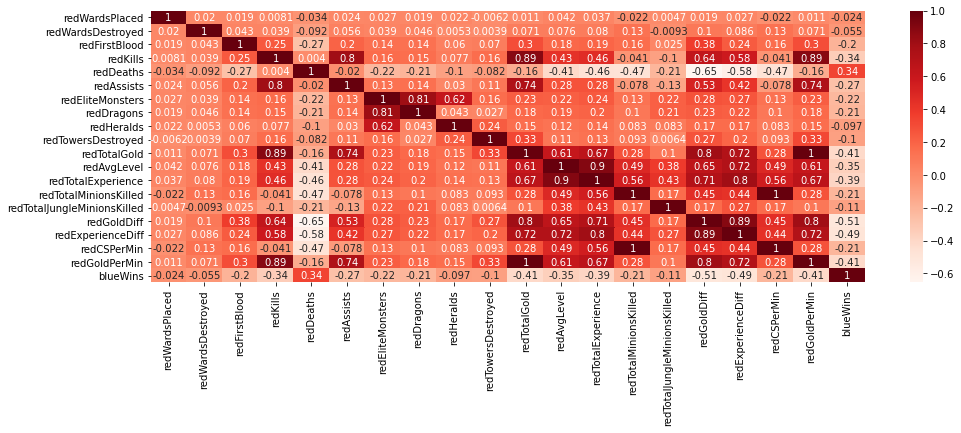

In [124]:
plt.figure(figsize=(16,5))
sns.heatmap(red.corr(),annot=True,cmap='Reds')

In [125]:
red.drop(['redWardsPlaced','redWardsDestroyed','redFirstBlood','redHeralds','redTowersDestroyed','redTotalJungleMinionsKilled','blueWins'],axis=1,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [126]:
red.shape

(9879, 13)

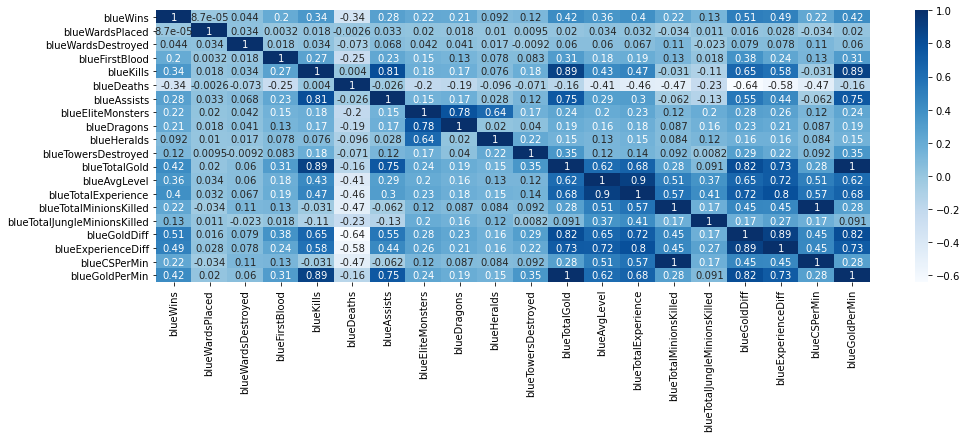

In [127]:
plt.figure(figsize=(16,5))
sns.heatmap(blue.corr(),annot=True,cmap='Blues')

In [128]:
blue.drop(['blueWardsPlaced','blueWardsDestroyed','blueFirstBlood','blueHeralds','blueTowersDestroyed', 'blueTotalJungleMinionsKilled'],axis=1,inplace=True)

In [129]:
blue.shape

(9879, 14)

In [130]:
dataframe=pd.concat([blue,red],axis=1)
dataframe.shape

(9879, 27)

All the low correlated input data have been removed which will greatly improve the overall results of the model. There are a few other columns that can be dropped as well. Some of the columns are directly related to each other. For instance the columns `blueDeaths` and `redKills`, and `redGoldDiff` is equal to the difference between the values of `redTotalGold` and `blueTotalGold`. Some of the redundant columns thus needs to be removed as they do not add value.

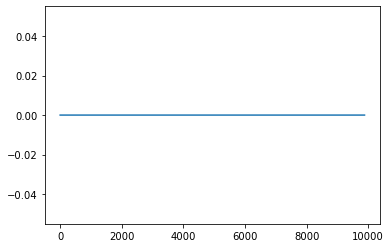

In [131]:
plt.plot(dataframe["blueDeaths"]-dataframe["redKills"])

In [132]:
dataframe.drop(['redTotalGold','blueTotalGold','redTotalExperience','blueTotalExperience','blueGoldDiff','blueExperienceDiff','blueKills','blueDeaths'], axis=1, inplace=True)
print(dataframe.shape)
dataframe.head()

(9879, 19)


,blueWins,blueAssists,blueEliteMonsters,blueDragons,blueAvgLevel,blueTotalMinionsKilled,blueCSPerMin,blueGoldPerMin,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redAvgLevel,redTotalMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,11,0,0,6.6,195,19.5,1721.0,6,9,8,0,0,6.8,197,-643,8,19.7,1656.7
1,0,5,0,0,6.6,174,17.4,1471.2,5,5,2,2,1,6.8,240,2908,1173,24.0,1762.0
2,0,4,1,1,6.4,186,18.6,1611.3,11,7,14,0,0,6.8,203,1172,1033,20.3,1728.5
3,0,5,1,0,7.0,201,20.1,1515.7,5,4,10,0,0,7.0,235,1321,7,23.5,1647.8
4,0,6,0,0,7.0,210,21.0,1640.0,6,6,7,1,1,7.0,225,1004,-230,22.5,1740.4


The input columns have been reduced from `(9879, 40)` to `(9879, 19)`.

## Model fitting and prediction

The model fitting exercise will follow an iterative process of improving the model using what has been learned during the course. The first model that will be evaluated is *Linear regression*

### Linear regression model

The output and input columns are first specified

In [133]:
output_cols = [dataframe.keys()[0]]
output_cols

['blueWins']

In [134]:
num_rows = len(dataframe.index)
print(f"The dataframe has {num_rows} rows")
num_cols = len(dataframe.columns)
print(f"The dataframe has {num_cols} columns")
input_cols = dataframe.keys()[1:]
print(f"The input columns are: {input_cols}")

The dataframe has 9879 rows
The dataframe has 19 columns
The input columns are: Index(['blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueAvgLevel',
       'blueTotalMinionsKilled', 'blueCSPerMin', 'blueGoldPerMin', 'redKills',
       'redDeaths', 'redAssists', 'redEliteMonsters', 'redDragons',
       'redAvgLevel', 'redTotalMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')


In [135]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [136]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[1.1000e+01, 0.0000e+00, 0.0000e+00, ..., 8.0000e+00, 1.9700e+01,
         1.6567e+03],
        [5.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.1730e+03, 2.4000e+01,
         1.7620e+03],
        [4.0000e+00, 1.0000e+00, 1.0000e+00, ..., 1.0330e+03, 2.0300e+01,
         1.7285e+03],
        ...,
        [5.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.8770e+03, 2.6100e+01,
         1.8319e+03],
        [3.0000e+00, 1.0000e+00, 1.0000e+00, ..., 1.0850e+03, 2.4700e+01,
         1.5298e+03],
        [5.0000e+00, 0.0000e+00, 0.0000e+00, ..., 5.8000e+01, 2.0100e+01,
         1.5339e+03]]),
 array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [1]]))

In [137]:
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)

In [138]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [139]:
dataset = TensorDataset(inputs, targets)

Once the dataset has been transformed to a tensor dataset, it will be split intor three groups:

* Training dataset
* Validation dataset
* Testing dataset

In [140]:
val_percent = 0.1 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
test_size = val_size
train_size = num_rows - val_size - test_size
print(f"Total size: {num_rows} \nTesting size: {train_size} \nValidation size: {val_size} \nTesting size: {test_size}")

train_ds, val_ds, test_ds = random_split(dataset,[train_size, val_size, test_size])

Total size: 9879 
Testing size: 7905 
Validation size: 987 
Testing size: 987


In [141]:
batch_size = 256

In [142]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [143]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[ 2.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  2.8560e+03,
          2.1500e+01,  1.7811e+03],
        [ 7.0000e+00,  1.0000e+00,  1.0000e+00,  ..., -7.6600e+02,
          2.0900e+01,  1.6080e+03],
        [ 6.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.0450e+03,
          2.2600e+01,  1.6345e+03],
        ...,
        [ 3.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  4.0000e+00,
          2.3300e+01,  1.6863e+03],
        [ 4.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -4.8900e+02,
          2.0600e+01,  1.5168e+03],
        [ 6.0000e+00,  1.0000e+00,  1.0000e+00,  ..., -1.8000e+01,
          2.2000e+01,  1.8074e+03]])
targets: tensor([[0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
 

A threshold value of 50% is specified for validation purposes.

In [144]:
input_size = len(input_cols)
print(f"Number of input variables: {input_size}")
output_size = len(output_cols)
print(f"Number of output variables: {output_size}")
threshold = 0.5

Number of input variables: 18
Number of output variables: 1


In [145]:
def accuracy(outputs, labels):
    return torch.tensor(torch.sum(abs(outputs-labels) < threshold).item() / len(outputs))

In [146]:
class LeagueOfLegendsModel(nn.Module):
    def __init__(self):
        # initiate the model
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, xb):
        # forward function of the model 
        out = self.sigmoid(self.linear(xb))
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.smooth_l1_loss(out, targets)                               # fill this
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.mse_loss(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [147]:
model = LeagueOfLegendsModel()

In [148]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1792, -0.0536,  0.0292, -0.1067, -0.2041, -0.1767, -0.1751, -0.0189,
           0.2009,  0.1875, -0.0926, -0.2329, -0.1874, -0.2212, -0.0005, -0.0675,
          -0.1115,  0.1267]], requires_grad=True),
 Parameter containing:
 tensor([0.1076], requires_grad=True)]

In [149]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [150]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [151]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [152]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [153]:
model = LeagueOfLegendsModel()
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.4027031660079956, 'val_acc': 0.593549370765686}]

In [154]:
epochs = 30
lr = 0.001
history += fit(epochs, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2951, val_acc: 0.7014
Epoch [1], val_loss: 0.2913, val_acc: 0.7048
Epoch [2], val_loss: 0.2891, val_acc: 0.7049
Epoch [3], val_loss: 0.2914, val_acc: 0.7056
Epoch [4], val_loss: 0.2866, val_acc: 0.7103
Epoch [5], val_loss: 0.2896, val_acc: 0.7077
Epoch [6], val_loss: 0.2819, val_acc: 0.7139
Epoch [7], val_loss: 0.2840, val_acc: 0.7136
Epoch [8], val_loss: 0.2825, val_acc: 0.7167
Epoch [9], val_loss: 0.2838, val_acc: 0.7147
Epoch [10], val_loss: 0.2839, val_acc: 0.7146
Epoch [11], val_loss: 0.2835, val_acc: 0.7146
Epoch [12], val_loss: 0.2858, val_acc: 0.7136
Epoch [13], val_loss: 0.2853, val_acc: 0.7126
Epoch [14], val_loss: 0.2814, val_acc: 0.7170
Epoch [15], val_loss: 0.2834, val_acc: 0.7152
Epoch [16], val_loss: 0.2821, val_acc: 0.7141
Epoch [17], val_loss: 0.2801, val_acc: 0.7183
Epoch [18], val_loss: 0.2785, val_acc: 0.7185
Epoch [19], val_loss: 0.2855, val_acc: 0.7106
Epoch [20], val_loss: 0.2819, val_acc: 0.7145
Epoch [21], val_loss: 0.2753, val_acc: 0.723

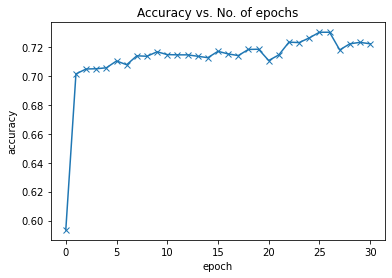

In [155]:
plot_accuracies(history)

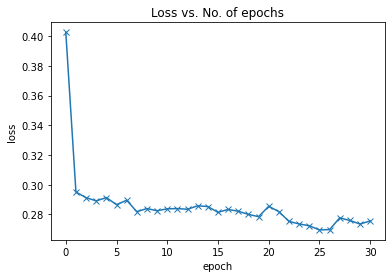

In [156]:
plot_losses(history)

In [198]:
import jovian
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/asvn90/my-project-Leagure-of-Legends


<IPython.core.display.Javascript object>

## Feed forward neural network

In [158]:
input_size

18

In [159]:
layers = [input_size, 32, 64, 128, 128, 64, 32, 16, output_size]

In [160]:
class LeagueOfLegendsModel2(LeagueOfLegendsModel):
    def __init__(self, layers):
        super().__init__()
        number_of_layers = len(layers)
        self.linears = nn.ModuleList()
        # n hidden layer and output layer - really cool way to write it as shown by @anivorlis
        for hs1, hs2 in zip(layers[:-1], layers[1:]):
            self.linears.append(nn.Linear(hs1, hs2))
        
    def forward(self, xb):
        out = xb
        # Apply layers & activation functions
        for linear in self.linears[:-1]:
            out = linear(out)
            out = F.relu(out)
        # Get predictions using output layer
        out = self.linears[-1](out)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                               # fill this
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.l1_loss(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def epoch_end(self, epoch, result, num_epochs):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [161]:
model = LeagueOfLegendsModel2(layers)
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.7572009563446045, 'val_acc': 0.4997591972351074}]

In [162]:
epochs = 30
lr = 1e-5
history += fit(epochs, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7119, val_acc: 0.5017
Epoch [1], val_loss: 0.6758, val_acc: 0.5017
Epoch [2], val_loss: 0.6433, val_acc: 0.5017
Epoch [3], val_loss: 0.6131, val_acc: 0.5017
Epoch [4], val_loss: 0.5862, val_acc: 0.5017
Epoch [5], val_loss: 0.5632, val_acc: 0.5017
Epoch [6], val_loss: 0.5426, val_acc: 0.5017
Epoch [7], val_loss: 0.5234, val_acc: 0.5058
Epoch [8], val_loss: 0.5058, val_acc: 0.5198
Epoch [9], val_loss: 0.4896, val_acc: 0.5364
Epoch [10], val_loss: 0.4743, val_acc: 0.5654
Epoch [11], val_loss: 0.4600, val_acc: 0.5751
Epoch [12], val_loss: 0.4470, val_acc: 0.5922
Epoch [13], val_loss: 0.4352, val_acc: 0.6002
Epoch [14], val_loss: 0.4250, val_acc: 0.6157
Epoch [15], val_loss: 0.4158, val_acc: 0.6238
Epoch [16], val_loss: 0.4077, val_acc: 0.6274
Epoch [17], val_loss: 0.4003, val_acc: 0.6347
Epoch [18], val_loss: 0.3940, val_acc: 0.6431
Epoch [19], val_loss: 0.3887, val_acc: 0.6432
Epoch [20], val_loss: 0.3842, val_acc: 0.6465
Epoch [21], val_loss: 0.3803, val_acc: 0.649

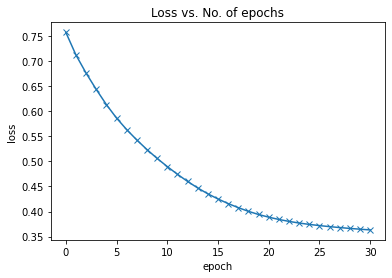

In [163]:
plot_losses(history)

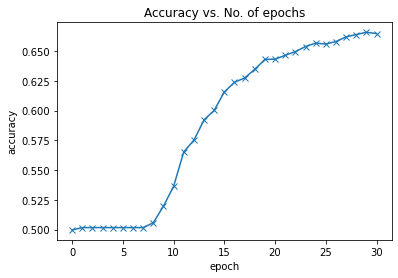

In [164]:
plot_accuracies(history)

In [165]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/asvn90/my-project-Leagure-of-Legends


<IPython.core.display.Javascript object>

## Plase holder

In [166]:
class LeagueOfLegendsModel3(LeagueOfLegendsModel2):
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [167]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [168]:
model = LeagueOfLegendsModel3(layers)

In [169]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.7603615522384644, 'val_acc': 0.37910690903663635}]

In [170]:
epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.AdamW

In [171]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00003, train_loss: 0.5968, val_loss: 0.4044, val_acc: 0.6694
Epoch [1], last_lr: 0.00008, train_loss: 0.3696, val_loss: 0.3156, val_acc: 0.7142
Epoch [2], last_lr: 0.00010, train_loss: 0.3057, val_loss: 0.3019, val_acc: 0.7281
Epoch [3], last_lr: 0.00010, train_loss: 0.2989, val_loss: 0.3032, val_acc: 0.7302
Epoch [4], last_lr: 0.00008, train_loss: 0.2953, val_loss: 0.2957, val_acc: 0.7290
Epoch [5], last_lr: 0.00006, train_loss: 0.2925, val_loss: 0.2972, val_acc: 0.7290
Epoch [6], last_lr: 0.00004, train_loss: 0.2922, val_loss: 0.2938, val_acc: 0.7290
Epoch [7], last_lr: 0.00002, train_loss: 0.2905, val_loss: 0.2939, val_acc: 0.7302
Epoch [8], last_lr: 0.00000, train_loss: 0.2900, val_loss: 0.2932, val_acc: 0.7302
Epoch [9], last_lr: 0.00000, train_loss: 0.2895, val_loss: 0.2933, val_acc: 0.7302
CPU times: user 7.46 s, sys: 5.14 s, total: 12.6 s
Wall time: 4.28 s


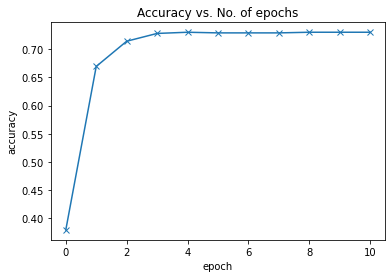

In [172]:
plot_accuracies(history)

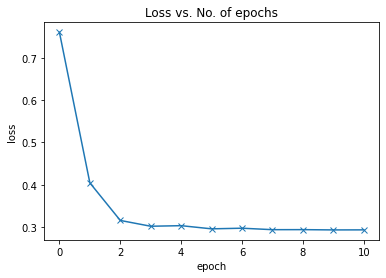

In [173]:
plot_losses(history)

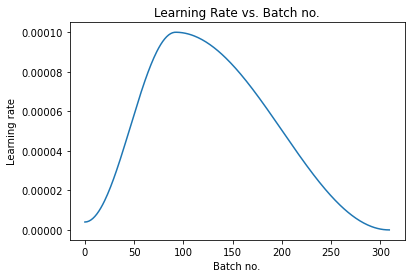

In [174]:
plot_lrs(history)

### Test model with test data

In [190]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)     
    prediction = predictions[0].detach()
    #print("Input:", input)
    #print("Target:", target)
    #print("Prediction:", accuracy(prediction, target))
    return accuracy(prediction, target)

In [195]:
success = 0
for i in range(len(test_ds)):
    input, target = test_ds[i]
    if predict_single(input, target, model) == target:
        success += 1


In [197]:

print(f"Accuracy when using the test dataset: {success/len(test_ds)}")

Accuracy when using the test dataset: 0.49645390070921985


In [176]:
model_performance = []
for i in range(len(test_ds)):
    input, target = test_ds[i]
    model_performance.append(predict_single(input, target, model))

In [178]:
def accuracy(outputs, labels):
    return torch.tensor(torch.sum(abs(outputs-labels) < threshold).item() / len(outputs))